In [289]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Importing Necessary Libraries**

In [290]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

**Finding a set of ground-truth correspondences**

In [301]:
def correspond(img1,img2,K):
  # Create SIFT object
  sift = cv2.xfeatures2d.SIFT_create()

  # Find keypoints and descriptors in both images
  kp1, des1 = sift.detectAndCompute(img1, None)
  kp2, des2 = sift.detectAndCompute(img2, None)

  # Create matcher object
  matcher = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)

  # Match the descriptors
  matches = matcher.match(des1, des2)

  sorted_matches = [matches[0]]
  for match in matches[1:]:
      for i, sorted_match in enumerate(sorted_matches):
          if match.distance < sorted_match.distance:
              sorted_matches.insert(i, match)
              break
      else:
          sorted_matches.append(match)
  good_matches=sorted_matches[:100]



  # Draw the matches
  img_matches = cv2.drawMatches(img1, kp1, img2, kp2, good_matches[0:200], None, flags=2)

  # Extract the matched keypoints

  src_pts = np.float32([kp1[m.queryIdx].pt for m in good_matches[0:200]]).reshape(-1, 1, 2)
  dst_pts = np.float32([kp2[m.trainIdx].pt for m in good_matches[0:200]]).reshape(-1, 1, 2)
  correspondences = []
  for i in range(len(src_pts)):
      correspondences.append(src_pts[i][0])
      correspondences.append(dst_pts[i][0])
  return img_matches,src_pts,dst_pts,correspondences


In [302]:
# Load the images and intrinsic matrix K
img1 = cv2.imread('/im1.jpg')
img2 = cv2.imread('/im2.jpg')
K = np.loadtxt('/Intrinsic_Matrix_K.txt')

img_matches,src_pts,dst_pts,correspondences=correspond(img1,img2,K)


p1=[]
p2=[]
for i in range(len(correspondences)):
    if(i%2==0):
        l=list(correspondences[i])
        l.append(1)
        p1.append(l)
    else:
        l=list(correspondences[i])
        l.append(1)
        p2.append(l)


In [303]:
print(src_pts)
print(p1)

[[[ 846.0506  1085.5927 ]]

 [[1035.1488   418.91513]]

 [[1012.94574  626.9541 ]]

 [[1061.1746   595.58966]]

 [[ 786.712   1081.3296 ]]

 [[1061.1746   595.58966]]

 [[ 993.0014   616.97296]]

 [[1046.4132   594.9424 ]]

 [[1039.0304   523.9314 ]]

 [[1054.4338   600.6898 ]]

 [[1016.361    557.24347]]

 [[1055.7719   593.5981 ]]

 [[1066.047    502.36108]]

 [[1094.8892   538.38306]]

 [[ 915.7164   579.4175 ]]

 [[ 733.77673  543.7252 ]]

 [[ 989.88385  603.9514 ]]

 [[ 690.102   1064.3629 ]]

 [[ 745.0188   568.3103 ]]

 [[1041.1284  1111.4731 ]]

 [[1076.878    591.54364]]

 [[ 734.4002   514.75415]]

 [[1076.5518   542.401  ]]

 [[ 903.3009  1100.2166 ]]

 [[1070.8768   578.37103]]

 [[ 883.79987 1119.2307 ]]

 [[ 994.00903  607.26874]]

 [[1017.347    413.3413 ]]

 [[ 993.0014   616.97296]]

 [[ 970.375    616.5083 ]]

 [[ 981.0781  1117.0719 ]]

 [[ 255.85579  729.1978 ]]

 [[1020.1844   559.45197]]

 [[ 987.7545   612.9675 ]]

 [[ 976.9827   544.4173 ]]

 [[ 964.8774   617.8

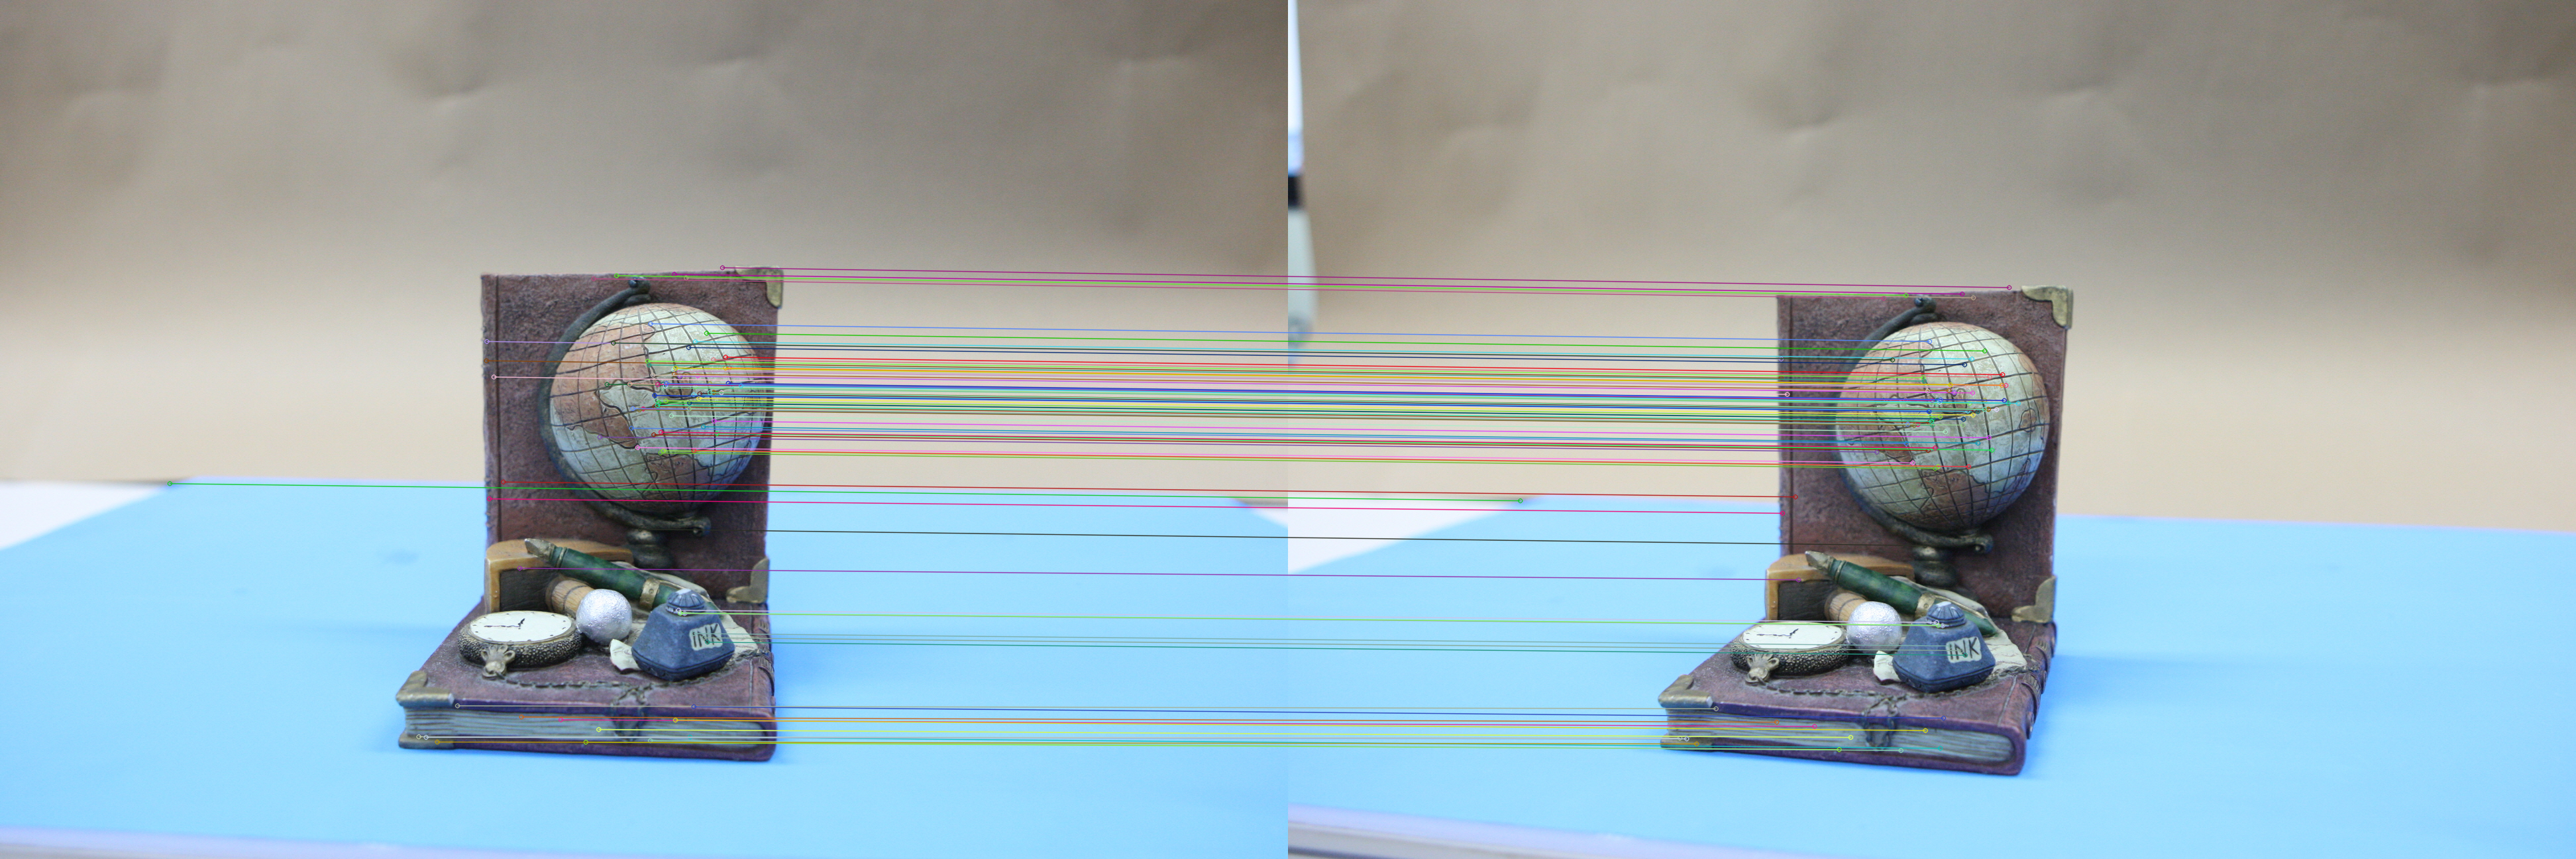

In [304]:
cv2_imshow( img_matches)

**Finding the Essential matrix E.**

In [320]:
def essent(a1,b1,k):
  A=[]
  for i in range(len(p1)):
      x1=np.linalg.inv(k)@a1[i]
      y1=np.linalg.inv(k)@b1[i]
      l=[x1[0]*y1[0],x1[1]*y1[0],y1[0],x1[0]*y1[1],x1[1]*y1[1],y1[1],x1[0],x1[1],1]
      A.append(l)
  A=np.array(A).reshape(len(p1),9)
  Mat=np.transpose(A)@A
  e,c=np.linalg.eigh(Mat)
  idx=np.argmin(e)
  E=c[:,idx]
  E=E.reshape(3,3)
  U, s, V = np.linalg.svd(E, full_matrices=True)
  idx1=np.argmin(s)
  s[idx1]=0
  sig=(s[0]+s[1]+s[2])/2
  s=[sig,sig,0]
  E=U@np.diag(s)@V
  return E,U,V

In [321]:
E,U,V=essent(p1,p2,K)
print(E)

[[ 0.00797246 -0.18799947 -0.11662825]
 [ 0.1261202  -0.0248958   0.68643113]
 [ 0.10079511 -0.67300107 -0.01200153]]


**Decomposition of obtained Essential matrix E**

In [327]:
def rotation_trans(essential,u,v):
  Rz1=[[0,-1,0],[1,0,0],[0,0,1]]
  Rz1=np.array(Rz1).reshape(3,3)
  R1=u@np.transpose(Rz1)@v
  Rz2=[[0,1,0],[-1,0,0],[0,0,1]]
  Rz2=np.array(Rz2).reshape(3,3)
  R2=u@np.transpose(Rz2)@u
  t1=u[:,2]
  t2=-u[:,2]
  # Selecting R1 and t1 as our final rotation matrix 
  R=R1
  t=t1
  return R,t


In [328]:
R,t=rotation_trans(E,U,V)

In [329]:
print(R)
print(t)

[[-0.8538945  -0.30002817  0.42526143]
 [-0.29091454  0.9526931   0.08800337]
 [ 0.43154712  0.04856914  0.90078195]]
[-0.9497246  -0.15662339  0.27109464]


**Finding 3D points**

In [330]:
def threeD_points(M,N,x,y):
  x_cross=np.array([[0,-1,x[1]],[1,0,x[0]],[-x[1],x[0],0]])
  y_cross=np.array([[0,-1,y[1]],[1,0,y[0]],[-y[1],y[0],0]])
  B=x_cross@M
  C=y_cross@N
  D=np.concatenate((B,C),axis=0)
  D=np.array(D).reshape(6,4)
  D=D.T@D
  eig_val,eig_vec=np.linalg.eigh(D)
  i=np.argmin(eig_val)
  return eig_vec[:,i]


In [331]:
M=K@np.concatenate((np.identity(3),np.zeros((3,1))),axis=1)
N=K@np.concatenate((R,t.reshape(3,1)),axis=1)
print(M)
print(N)

[[1.69887376e+03 0.00000000e+00 9.71749770e+02 0.00000000e+00]
 [0.00000000e+00 1.69887966e+03 6.47748827e+02 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00 0.00000000e+00]]
[[-1.03130314e+03 -4.62512934e+02  1.59780014e+03 -1.35002604e+03]
 [-2.14694651e+02  1.64997153e+03  7.32987596e+02 -9.04830535e+01]
 [ 4.31547122e-01  4.85691353e-02  9.00781950e-01  2.71094642e-01]]


In [332]:
P=[]
for i in range(len(p1)):
  Homo_point=threeD_points(M,N,p1[i],p2[i])
  P1=[Homo_point[0]/Homo_point[3],Homo_point[1]/Homo_point[3],Homo_point[2]/Homo_point[3]]
  P.append(P1)

P=np.array(P)
print(P)

[[-0.35677174 -0.30197954  0.44178908]
 [-0.42452409 -0.22135821  0.33082918]
 [-0.40104811 -0.25748137  0.33972623]
 [-0.40785911 -0.24873468  0.32903314]
 [-0.34922092 -0.28610708  0.4788381 ]
 [-0.40785911 -0.24873468  0.32903314]
 [-0.40004904 -0.25746122  0.34392156]
 [-0.40665068 -0.24981685  0.33199409]
 [-0.41258337 -0.23889397  0.3322459 ]
 [-0.4068812  -0.25010881  0.33048889]
 [-0.40732869 -0.24615333  0.33732307]
 [-0.40754214 -0.24883438  0.33006178]
 [-0.4170527  -0.23304983  0.32684401]
 [-0.4158188  -0.23667736  0.32204837]
 [-0.39564985 -0.25731953  0.36038606]
 [-0.37793415 -0.2627326   0.40675162]
 [-0.40084171 -0.25567799  0.34422983]
 [-0.33737075 -0.24639358  0.54687071]
 [-0.37709836 -0.26529377  0.40622176]
 [-0.37824412 -0.3229902   0.35231903]
 [-0.40954732 -0.24683071  0.32592729]
 [-0.38085301 -0.2590256   0.40322254]
 [-0.41393853 -0.23884884  0.32542711]
 [-0.36326357 -0.31253715  0.41189427]
 [-0.41014031 -0.24516517  0.32692052]
 [-0.3599712  -0.31043002

**Plotting**

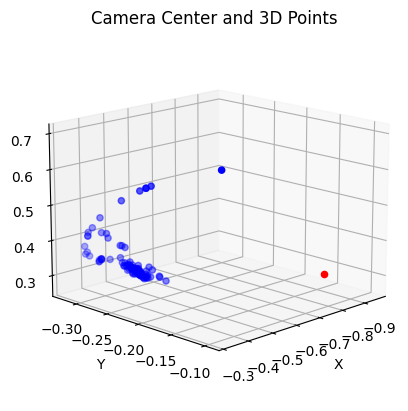

In [333]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.view_init(azim = 45, elev = 15)
ax.scatter(t[0], t[1], t[2], c='r')

# Plot the 3D points Pi as blue dots
ax.scatter(P[:,0], P[:,1], P[:,2], c='b')

# Set the axis labels and title
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Camera Center and 3D Points')

# Show the plot
plt.show()